## Informe Lab 1

Aquí se importan las librerías necesarias. elasticsearch para interactuar con Elasticsearch, argparse para manejar argumentos de línea de comandos, csv para escribir archivos CSV, y re para expresiones regulares.

In [47]:
%pip install elasticsearch
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install sklearn
%pip install scipy
%pip install nltk


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfi

In [48]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch.exceptions import NotFoundError, TransportError
import pandas as pd
import argparse
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import nltk
from nltk.corpus import stopwords



In [49]:
def is_valid_word(word):
    english_re = r"^[a-zA-Z-']+$"
    return bool(re.fullmatch(english_re, word))

ALLOW_STOPWORDS = True
nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
np.set_printoptions(suppress=True)


[nltk_data] Downloading package stopwords to /Users/nico/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Configuración del cliente de Elasticsearch


In [51]:
index = 'news'

In [52]:
# Configuramos el cliente de Elasticsearch
try:
    # Conectamos al cliente de Elasticsearch
    client = Elasticsearch(hosts=['http://localhost:9200'], request_timeout=1000)
    voc = {}
    
    # Escaneamos el índice para obtener los documentos
    sc = scan(client, index=index, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)


### Recolección de términos y sus frecuencias


In [53]:
for s in sc:
    tv = client.termvectors(index=index, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            if t in english_stopwords and not ALLOW_STOPWORDS:
                continue
            if t in voc:
                voc[t] += tv['term_vectors']['text']['terms'][t]['term_freq']
            else:
                voc[t] = tv['term_vectors']['text']['terms'][t]['term_freq']

print(voc)


/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/162005452.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  for s in sc:
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/162005452.py:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  tv = client.termvectors(index=index, id=s['_id'], fields=['text'])


{'1': 11898, '137': 21, '18': 964, '183': 19, '1984': 119, '1990': 407, '1991': 431, '2': 9318, '20': 1777, '201': 50, '21': 767, '223': 52, '3': 5721, '39': 247, '4': 4934, '45': 397, '46': 227, '47th': 2, '5': 3946, '6': 2975, '7': 2224, '8': 2555, '9': 1525, 'a': 107310, 'about': 14557, 'abstaining': 3, 'account': 481, 'affirming': 9, 'africa': 106, 'against': 2501, 'also': 7670, 'america': 526, 'and': 101530, 'appreciation': 10, 'as': 27944, 'asia': 53, 'assembly': 178, 'assistance': 158, 'at': 18374, 'australia': 267, 'aware': 432, 'banks': 228, 'basis': 653, 'bodies': 301, 'by': 19351, 'call': 1948, 'calls': 448, 'canada': 784, 'cannot': 1434, 'center': 1199, 'central': 231, 'certificates': 10, 'close': 738, 'community': 560, 'concerned': 398, 'concessions': 30, 'concrete': 134, 'cooperation': 114, 'council': 239, 'countries': 469, 'cpr': 106, 'crisis': 84, 'december': 197, 'develop': 287, 'development': 601, 'economic': 308, 'economy': 175, 'employment': 47, 'entry': 482, 'estab

### Filtrado y creación de la lista de palabras

In [37]:
lpal = []
# Filtramos las palabras válidas y las agregamos a la lista
for v in voc:
    lpal.append((v.encode("utf-8", "ignore"), voc[v]))
# Convertimos la lista a un DataFrame de pandas
df = pd.DataFrame(lpal, columns=['Word', 'Count'])
print(df.head())  # Mostramos las primeras filas del DataFrame


            Word   Count
0           b'a'  107310
1       b'about'   14557
2  b'abstaining'       3
3     b'account'     481
4   b'affirming'       9


### Ordenar el DataFrame

In [38]:
# Ordenamos las palabras por frecuencia
df_sorted = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Asignamos el ranking de las palabras
df_sorted['Ranking'] = df_sorted.index + 1  # El ranking empieza en 1

# Extraemos las palabras, sus frecuencias y los rankings
pal = df_sorted['Word'].values
freq = df_sorted['Count'].values
rankings = df_sorted['Ranking'].values


print(df_sorted.head())  # Mostramos las primeras filas del DataFrame ordenado



     Word   Count  Ranking
0  b'the'  257240        1
1   b'to'  129475        2
2   b'of'  116233        3
3    b'a'  107310        4
4  b'and'  101530        5


### Definición de leyes de Zipf

In [39]:
# Función de Zipf general
def zipf_function(rank, a, b, c):
    return a / (rank + b) ** c


In [40]:
# Computa los valores estimados según la ley de Zipf
def compute_zipf_estimated_values(ranks, a, b, c):
    return [zipf_function(rank, a, b, c) for rank in ranks]


In [41]:
# Encuentra los parámetros ajustados para la ley de Zipf
def find_curve_fit_values(function, xdata, ydata, initial_params):
    params, _ = curve_fit(function, xdata, ydata, p0=initial_params)
    return params


In [42]:
# Parámetros iniciales para la ley de Zipf
initial_params = [1, 0, max(freq)]

# Ajustamos los parámetros usando la función find_curve_fit_values
params = find_curve_fit_values(zipf_function, rankings, freq, initial_params)

# Calculamos los valores estimados de la ley de Zipf
zipf_estimations = compute_zipf_estimated_values(rankings, *params)


/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/3147462976.py:3: RuntimeWarning: overflow encountered in power
  return a / (rank + b) ** c
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/3147462976.py:3: RuntimeWarning: divide by zero encountered in divide
  return a / (rank + b) ** c
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/2337681655.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(function, xdata, ydata, p0=initial_params)
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_90882/3147462976.py:3: RuntimeWarning: overflow encountered in scalar power
  return a / (rank + b) ** c


### Visualización

In [43]:
# Definir la función para graficar con ambas escalas
def plot_both_scales(x, y, y_estimations, index_name, law):
    # Crea dos subgráficos (linear scale y log-log scale)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    # Gráfico 1: escala lineal
    ax1.plot(x, y, label="Real Frequencies")
    ax1.plot(x, y_estimations, label=f"{law} Estimation")
    ax1.set_title(f"Word Frequency for {index_name}")
    ax1.set_xlabel("Word Ranking")
    ax1.set_ylabel("Frequencies")
    ax1.legend()

    # Gráfico 2: escala log-log
    # Eliminar ceros de x y y
    x_filtered = x[y > 0]
    y_filtered = y[y > 0]
    y_estimations_filtered = y_estimations[y_estimations > 0]
    
    # Graficar con los valores filtrados
    ax2.plot(np.log(x_filtered), np.log(y_filtered), label="Real Frequencies")
    ax2.plot(np.log(x_filtered), np.log(y_estimations_filtered), label=f"{law} Estimation")
    
    ax2.set_title(f"Word Frequency for {index_name}. Log-Log Scale")
    ax2.set_xlabel("Log Word Ranking")
    ax2.set_ylabel("Log Frequencies")
    ax2.legend()

    # Muestra los subgráficos
    plt.show()


TypeError: '>' not supported between instances of 'list' and 'int'

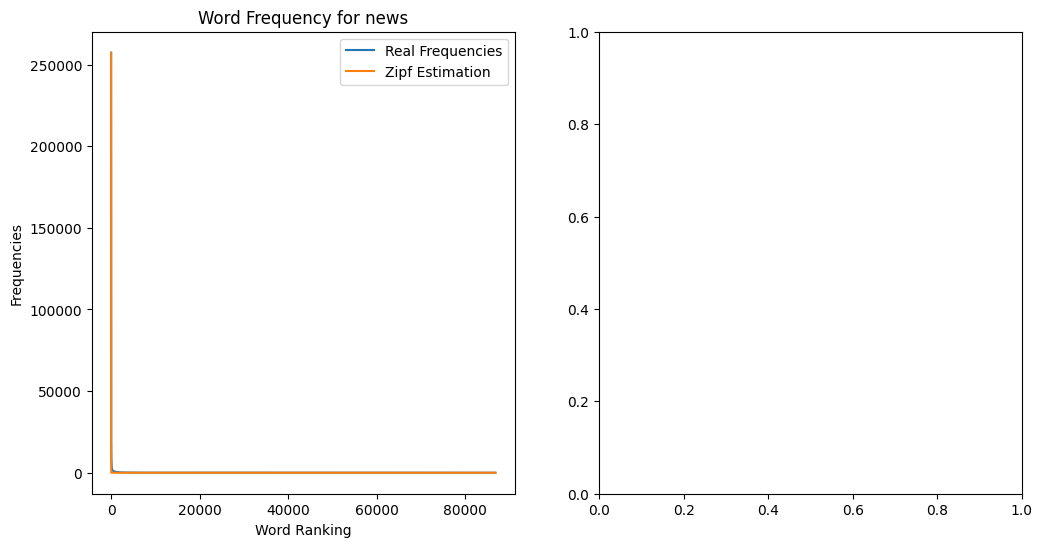

In [44]:
# Graficar con ambas escalas (lineal y log-log)
plot_both_scales(
    x=rankings,
    y=freq,
    y_estimations=zipf_estimations,
    index_name=index,  # Cambia esto por el nombre de tu índice si es necesario
    law="Zipf"
)
